## **1. Data Acquisition**

In [ ]:
# Importing necessary libraries for NHL data scraping and processing
import requests
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
import time
import json
import os
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns

**Code below defines base URL, and other key attributes like number of games, game type (regular season vs playoff), amongst other options.**

In [ ]:
# Key constants for NHL API
BASE_URL = "https://api-web.nhle.com/v1/gamecenter/"
years = [str(year) for year in range(2016, 2024)]  # range of seasons from 2016 to 2024
game_type = {'regular_season': '02', 'playoffs': '03'}  # game types
# Map the number of games for each season for regular season
num_games = {
    '2016': 1230, '2017': 1271, '2018': 1271, '2019': 1082,
    '2020': 868, '2021': 1312, '2022': 1312, '2023': 1312
}
# Generate game IDs for each season
game_ids = {year: [f"{year}{game_type['regular_season']}{str(game).zfill(4)}" for game in range(1, num_games[year] + 1)] for year in years}
num_rounds = 4
num_games_playoffs = 7
number_series = {1 : 8,
                 2 : 4,
                 3 : 2,
                 4 : 1}

# Generate game IDs for playoffs
game_ids_playoffs = {}
for year in years:
    game_ids_playoffs[year] = []
    for round_num in range(1, num_rounds + 1):
        for series in range(1, number_series[round_num] + 1):
            for game in range(1, num_games_playoffs + 1):
                game_id = f"{year}{game_type['playoffs']}{str(round_num).zfill(2)}{str(series)}{str(game)}"
                game_ids_playoffs[year].append(game_id)

In [ ]:
game_ids_playoffs['2016'][0]

'2016030111'

In [ ]:
# Generate all URLs for regular season and playoffs
urls = {year: [f"{BASE_URL}{game_id}/play-by-play" for game_id in game_ids[year]] for year in years}
urls_playoffs = {year: [f"{BASE_URL}{game_id}/play-by-play" for game_id in game_ids_playoffs[year]] for year in years}

In [ ]:
num_games_total = sum(len(v) for v in urls.values()) + sum(len(v) for v in urls_playoffs.values())
num_games_total

10498

**Creating NHLDataFetcher class which handles data fetching and processing for the NHL regular season and playoffs via the use of urls**

In [ ]:
# Create a class to handle NHL data fetching and processing
class NHLDataFetcher:
    def __init__(self, base_url, urls, urls_playoffs):
        self.base_url = base_url
        self.urls = urls
        self.urls_playoffs = urls_playoffs

    def fetch_data(self, url):
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from {url}: {e}")
            return None


    def process_game_data(self, data : Dict):
        if not data:
            return None

        # Normalize the plays data
        plays_df = pd.json_normalize(data['plays'])

        # Extract and add game info columns
        game_info = {
            'id': data.get('id'),
            'season': data.get('season'),
            'gameDate': data.get('gameDate'),
            'homeTeam_id': data.get('homeTeam', {}).get('id'),
            'homeTeam_abbrev': data.get('homeTeam', {}).get('abbrev'),
            'homeTeam_commonName_default': data.get('homeTeam', {}).get('commonName', {}).get('default'),
            'awayTeam_id': data.get('awayTeam', {}).get('id'),
            'awayTeam_abbrev': data.get('awayTeam', {}).get('abbrev'),
            'awayTeam_commonName_default': data.get('awayTeam', {}).get('commonName', {}).get('default')
        }

        plays_df = plays_df.assign(**game_info)
        plays_df.rename(columns = lambda col : col.replace('.', '_'), inplace=True)


        # Select only the desired columns
        desired_columns = [
            'id', 'season', 'gameDate',
            'homeTeam_id', 'homeTeam_abbrev', 'homeTeam_commonName_default',
            'awayTeam_id', 'awayTeam_abbrev', 'awayTeam_commonName_default',
            'eventId', 'periodDescriptor_number', 'periodDescriptor_periodType',
            'timeInPeriod', 'timeRemaining', 'typeCode', 'typeDescKey',
            'details_xCoord', 'details_yCoord', 'details_zoneCode', 'details_shotType',
            'details_shootingPlayerId', 'details_scoringPlayerId', 'details_goalieInNetId',
            'details_eventOwnerTeamId', 'situationCode', 'details_emptyNet', 'details_penaltyMinutes', 'details_penaltySeverityCode'
        ]

        plays_df = plays_df.reindex(columns=desired_columns)

        return plays_df

    def process_all_games(self, urls_dict):
        dfs = []
        for year, urls in urls_dict.items():
            len_urls = len(urls)
            print(f"Processing games of year {year}")
            for idx, url in enumerate(urls):
                data = self.fetch_data(url)
                game_df = self.process_game_data(data)
                if game_df is not None:
                    dfs.append(game_df)
                time.sleep(0.1)  # To avoid hitting the API rate limit
                batch_idx = (idx + 1) / len_urls * 100
                if batch_idx.is_integer() and batch_idx % 10 == 0 and batch_idx >= 1:
                    print(f"Processed {(idx + 1)} out of {len_urls} games ({(batch_idx):.2f}%)")
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        else:
            return pd.DataFrame()



**Testing URL and NHLDataFetcher Class**

In [ ]:
# Pick a random URL to test
test_url = urls['2023'][0] # First game of the 2023 season
test_url_playoffs = urls_playoffs['2023'][0]
test_url, test_url_playoffs

# Initialize the data fetcher
data_fetcher = NHLDataFetcher(BASE_URL, urls, urls_playoffs)

# Test with a sample URL for fetching data for a single game
sample_data = data_fetcher.fetch_data(test_url)
sample_df = data_fetcher.process_game_data(sample_data)
print(sample_df.head())
print(sample_df['details_penaltyMinutes'].isna().sum(), "NaN values out of", len(sample_df))
print(sample_df['details_penaltyMinutes'].unique())
print(sample_df['details_penaltySeverityCode'].isna().sum(), "NaN values out of", len(sample_df))
print(sample_df['details_penaltySeverityCode'].unique())

           id    season    gameDate  homeTeam_id homeTeam_abbrev  \
0  2023020001  20232024  2023-10-10           14             TBL   
1  2023020001  20232024  2023-10-10           14             TBL   
2  2023020001  20232024  2023-10-10           14             TBL   
3  2023020001  20232024  2023-10-10           14             TBL   
4  2023020001  20232024  2023-10-10           14             TBL   

  homeTeam_commonName_default  awayTeam_id awayTeam_abbrev  \
0                   Lightning           18             NSH   
1                   Lightning           18             NSH   
2                   Lightning           18             NSH   
3                   Lightning           18             NSH   
4                   Lightning           18             NSH   

  awayTeam_commonName_default  eventId  ...  details_zoneCode  \
0                   Predators      102  ...               NaN   
1                   Predators      101  ...                 N   
2                   Pre

In [ ]:
# Processing data for an entire season
season_df = data_fetcher.process_all_games({'2016': urls['2016']})
print(season_df.shape)

Processing games of year 2016
Processed 123 out of 1230 games (10.00%)


**Tidy Data (Creating Pandas Dataframe)**

In [ ]:
# Creating Pandas Dataframe of NHL Data between 2016 - 2021 including both regular season games and playoffs
all_regular_season_df = data_fetcher.process_all_games(urls)
all_playoffs_df = data_fetcher.process_all_games(urls_playoffs)
all_games_df = pd.concat([all_regular_season_df, all_playoffs_df], ignore_index=True)
all_games_df.to_csv('nhl_all_games_data.csv', index=False)

Processing games of year 2016
Processed 123 out of 1230 games (10.00%)
Processed 246 out of 1230 games (20.00%)
Processed 369 out of 1230 games (30.00%)
Processed 492 out of 1230 games (40.00%)
Processed 615 out of 1230 games (50.00%)
Processed 738 out of 1230 games (60.00%)
Processed 861 out of 1230 games (70.00%)
Processed 984 out of 1230 games (80.00%)
Processed 1107 out of 1230 games (90.00%)
Processed 1230 out of 1230 games (100.00%)
Processing games of year 2017
Processed 1271 out of 1271 games (100.00%)
Processing games of year 2018
Processed 1271 out of 1271 games (100.00%)
Processing games of year 2019
Processed 541 out of 1082 games (50.00%)
Processed 1082 out of 1082 games (100.00%)
Processing games of year 2020
Processed 434 out of 868 games (50.00%)


**Exploration of pandas data frame using head(50)**

In [ ]:
all_games_df.head(50)

NameError: name 'all_games_df' is not defined

**Further Exploration of Pandas Dataframe**

In [ ]:
# Futher exploration of the data set
all_games_df['id'].nunique(), all_games_df['season'].nunique(), all_games_df['typeDescKey'].nunique()
all_games_df.info()
all_games_df.describe()

# **2. Feature Engineering**

**a)** **Histograms of Distance and Angles from Net relationship against Goals Scored**

Training and Validation set: (1281286, 26)
Final test set shape: (0, 26)
    distance_from_net  angle_from_net  is_goal  empty_net
7           13.000000       22.619865        0          0
14          13.341664       77.005383        0          0
21          76.157731       29.931512        0          0
23          57.974132       14.995079        0          0
36          61.717096       26.980231        0          0


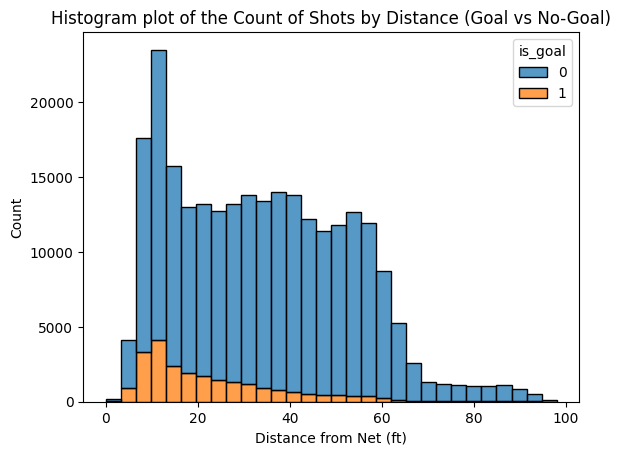

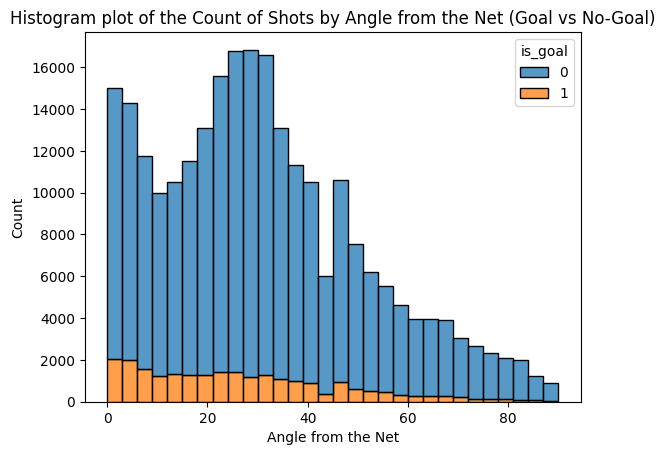

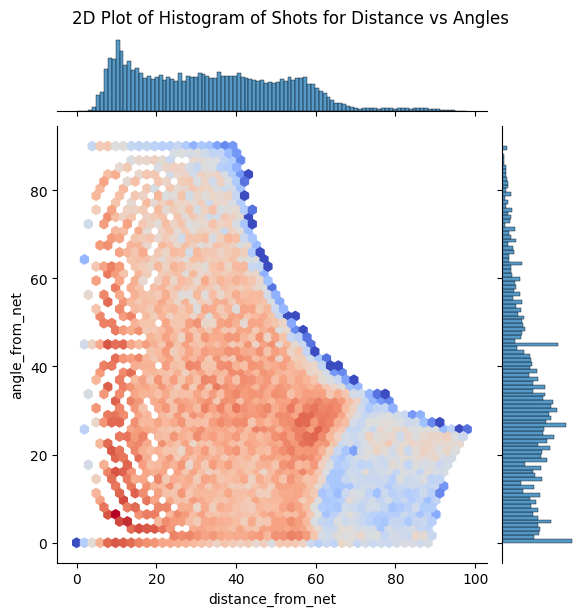

In [ ]:
all_games_df = pd.read_csv('nhl_all_games_data.csv')

# 1. Splitting data into training and test sets
# Data for seasons between 2016 to 2020 are training and validation sets, 2020/2021 season data is the data for the final test set
# Defining the training and validation data frame
train_valid_df = all_games_df[all_games_df['season'].astype('str').between('2016','2019')]
test_final_df = all_games_df[all_games_df['season'].astype('str') == '2020']

# 2. Printing out shapes for training, validation, and test set
print(f"Training and Validation set: {train_valid_df.shape}")
print(f"Final test set shape: {test_final_df.shape}")

# 3. Filtering only on shot-on-goal and goal events
shots_df = train_valid_df[train_valid_df['typeDescKey'].isin(['shot-on-goal', 'goal'])].copy()

# 4. Standardizing the direction of all shots to ensure that they face the same net
shots_df['x_standardized'] = np.where(shots_df['details_xCoord'] < 0,
                                      -shots_df['details_xCoord'],
                                      shots_df['details_xCoord'])
shots_df['y_standardized'] = np.where(shots_df['details_xCoord'] < 0,
                                      -shots_df['details_yCoord'],
                                      shots_df['details_yCoord'])

# 5. Calculate the angles from the net and distance from the net
# We assume that the net can be at the position (89, 0)
def compute_angles_distance(x,y):
  x_net, y_net = 89, 0
  dx = x_net - x
  dy = y_net - y
  # Defining Distance and Angles
  dist = np.sqrt(dx**2 + dy**2)
  # Angles are converted to degrees
  ang = np.degrees(np.arctan2(abs(dy), abs(dx)))
  return dist, ang


# 6. Defining the Shots Data frame
shots_df['distance_from_net'], shots_df['angle_from_net'] = zip(*shots_df.apply(lambda r: compute_angles_distance(r["x_standardized"], r["y_standardized"]), axis=1))

# 7. Creating the Is Goal and Empty Net column
shots_df["is_goal"] = np.where(shots_df["typeDescKey"]== "goal", 1, 0)
shots_df["empty_net"] = np.where(
    shots_df["details_goalieInNetId"].isna(), 1, 0
)


# 8. Selecting the final tidy data set for shots
tidy_shots_data = shots_df[['distance_from_net', 'angle_from_net', 'is_goal', 'empty_net']]
# Printing tidy shots table
print(tidy_shots_data.head())

# 9. Visualizations
# a) Histogram of shot counts (goals and no goals separated) binned by distance
sns.histplot(data=tidy_shots_data, x="distance_from_net", hue="is_goal", multiple='stack', bins=30)
plt.title("Histogram plot of the Count of Shots by Distance (Goal vs No-Goal)")
plt.xlabel("Distance from Net (ft)")
plt.ylabel("Count")
plt.show()

# b) Histogram of shot counts (goals and no goals separated) binned by angle
sns.histplot(data=tidy_shots_data, x="angle_from_net", hue="is_goal", multiple="stack", bins=30, palette=['#1f77b4', '#ff7f0e'])
plt.title("Histogram plot of the Count of Shots by Angle from the Net (Goal vs No-Goal)")
plt.xlabel("Angle from the Net")
plt.ylabel("Count")
plt.show()

# c) 2D Plot of Histogram of distance vs angle:
sns.jointplot(data=tidy_shots_data, x="distance_from_net", y="angle_from_net", kind="hex", bins="log", cmap="coolwarm")
plt.suptitle("2D Plot of Histogram of Shots for Distance vs Angles", y=1.02)
plt.show()

In [ ]:
print(shots_df["empty_net"].unique())
print(shots_df["empty_net"].value_counts(dropna=False))


[0 1]
empty_net
0    252335
1      1140
Name: count, dtype: int64


**b)** **Angles and Distance Plots Continued**

/tmp/ipython-input-4003250488.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("distance_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))
/tmp/ipython-input-4003250488.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("angle_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))


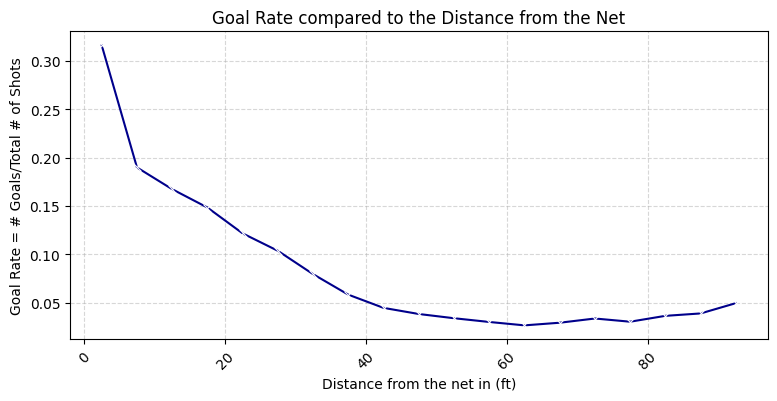

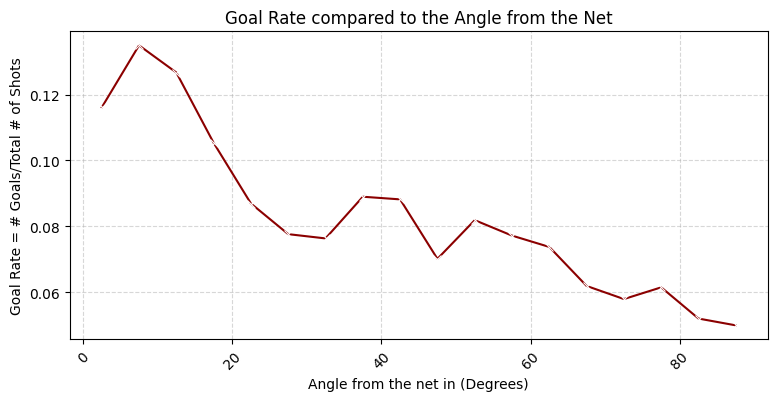

In [ ]:
## Defining bins for the histogram to make the plots more interpretable

# 1. Binning the data by distance and then computing the goal rate for distance
# Distance from 0 to 100 in increments of 5
bins_distance = np.arange(0, 100, 5)
dist_goal_rate = (tidy_shots_data.assign(distance_bin=pd.cut(tidy_shots_data['distance_from_net'], bins=bins_distance))
.groupby("distance_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))
.assign(goal_rate=lambda df: df['goals'] / df['total'])
.reset_index())

# Convert distance bins to their midpoints for plotting
dist_goal_rate['distance_mid'] = dist_goal_rate['distance_bin'].apply(lambda x: x.mid)

#2. Binning the data by angle and then computing the goal rate for distance
# Distance from 0 to 90 in increments of 5
bins_angle = np.arange(0, 91, 5)
ang_goal_rate = (tidy_shots_data.assign(angle_bin=pd.cut(tidy_shots_data['angle_from_net'], bins=bins_angle))
.groupby("angle_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))
.assign(goal_rate=lambda df: df['goals'] / df['total'])
.reset_index())

# Convert angle bins to midpoints for plotting
ang_goal_rate['angle_mid'] = ang_goal_rate['angle_bin'].apply(lambda x: x.mid)

#3. Plotting the Histogram for Goal Rate vs Distance
plt.figure(figsize=(9,4))
sns.lineplot(data=dist_goal_rate, x='distance_mid', y='goal_rate', marker='x', color='darkblue')
plt.title("Goal Rate compared to the Distance from the Net")
plt.xlabel("Distance from the net in (ft)")
plt.ylabel("Goal Rate = # Goals/Total # of Shots")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#4. Plotting Histogram for Goal Rate vs Angle
plt.figure(figsize=(9,4))
sns.lineplot(data=ang_goal_rate, x='angle_mid', y='goal_rate', marker='x', color='darkred')
plt.title("Goal Rate compared to the Angle from the Net")
plt.xlabel("Angle from the net in (Degrees)")
plt.ylabel("Goal Rate = # Goals/Total # of Shots")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**c) Sanity Check for Goals Empty vs Non-Empty Net**

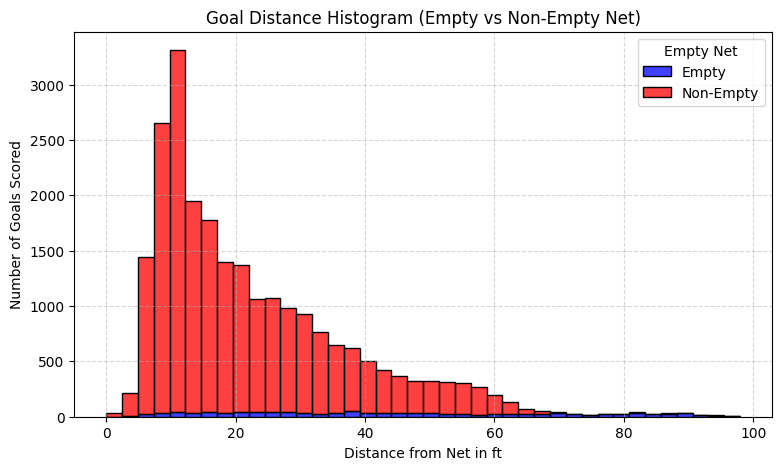

empty_net
0    252335
1      1140
Name: count, dtype: int64

 Possible Anomalous/Outlier Non-Empty Net Goals
No outliers found, all non-empty goals occur within the expected range of (<110 ft).

Distance summary for non-empty goals:
count    22664.000000
mean        21.825406
std         14.066891
min          0.000000
25%         10.770330
50%         17.464249
75%         29.698485
max         94.847246
Name: distance_from_net, dtype: float64

Distance summary for empty-net goals:
count    1139.000000
mean       44.993859
std        25.676274
min         2.000000
25%        23.000000
50%        41.868843
75%        66.943983
max        97.989795
Name: distance_from_net, dtype: float64


In [ ]:
# 1. Creating Goals data frame
goals_data = tidy_shots_data[tidy_shots_data["is_goal"]==1].copy()

# 2. Creating bins by distance
# Setting up a larger distance range in order to account for a full rink if necessary
bins_distance = np.arange(0, 200, 5)
goals_data["distance_bin"] = pd.cut(goals_data["distance_from_net"], bins=bins_distance)

# 3. Plotting the histogram separated by an empty net
plt.figure(figsize=(9,5))
sns.histplot(data=goals_data,
             x="distance_from_net",
             hue="empty_net",
             multiple="stack",
             bins=40,
             palette={0: "red", 1: "blue"},)
plt.title("Goal Distance Histogram (Empty vs Non-Empty Net)")
plt.xlabel("Distance from Net in ft")
plt.ylabel("Number of Goals Scored")
plt.legend(title="Empty Net", labels=["Empty", "Non-Empty"])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print(tidy_shots_data["empty_net"].value_counts(dropna=False))

## Detecting Anomalies section

# 4. Define distance threshold for anomaly detection
threshold = 110
outliers = goals_data[(goals_data["empty_net"]==0) & (goals_data["distance_from_net"] > threshold)]

print("\n Possible Anomalous/Outlier Non-Empty Net Goals")
if outliers.empty:
    print("No outliers found, all non-empty goals occur within the expected range of (<110 ft).")
else:
    print(f" Found {len(outliers)} potential outliers:")
    display(outliers[["distance_from_net", "angle_from_net", "empty_net"]].head(10))

# (Optional) Summary stats for insight
print("\nDistance summary for non-empty goals:")
print(goals_data[goals_data["empty_net"] == 0]["distance_from_net"].describe())

print("\nDistance summary for empty-net goals:")
print(goals_data[goals_data["empty_net"] == 1]["distance_from_net"].describe())



# **3. Baseline Models**

**a) Logistic Regression and Distance**

In [ ]:
## Import train test split, Logistic Regression, and other performance metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import wandb
import joblib

# 1. Dropping NA values from distance and is goal
tidy_shots_data = tidy_shots_data.dropna(subset=["distance_from_net", "is_goal"])

# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    # notes="commit message for the run",
    name="Logistic Regression Accuracy"
)

# 1. Defining distance as the only feature and is_goal as the target
X = tidy_shots_data[["distance_from_net"]]
y = tidy_shots_data["is_goal"]

# 2. Perform the train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Printing the size of the training and test set
print(f"This is the size of the training set: {X_train.shape[0]}")
print(f"This is this the size of test set: {X_val.shape[0]}")

# 3. Implementing the Logistic Regression Model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 4. Evaluating the model on the validation set
y_predicted = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)

# Log metrics
wandb.log({
    "accuracy": accuracy,
    })

# Create Artifact object
joblib.dump(clf, 'logistic_regression_model.pkl')
model_artifact = wandb.Artifact(name='logistic_regression_model', type='model')
model_artifact.add_file('logistic_regression_model.pkl')
wandb.log_artifact(model_artifact)

# Finish the run
wandb.finish()

# 5. Performance Metrics
print(f"\n The Validation Accuracy is: {accuracy:.4f}")
print("\n The Classification Report is:")
print(classification_report(y_val, y_predicted, target_names=["No Goal", "Goal"]))

print("\n The Confusion Matrix is:")
print(confusion_matrix(y_val, y_predicted))

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sina-vali (IFT6758-2025-B08) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


This is the size of the training set: 202767
This is this the size of test set: 50692


accuracy,▁
accuracy,0.90608



 The Validation Accuracy is: 0.9061

 The Classification Report is:
              precision    recall  f1-score   support

     No Goal       0.91      1.00      0.95     45931
        Goal       0.00      0.00      0.00      4761

    accuracy                           0.91     50692
   macro avg       0.45      0.50      0.48     50692
weighted avg       0.82      0.91      0.86     50692


 The Confusion Matrix is:
[[45931     0]
 [ 4761     0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**b) i)  ROC Curve**

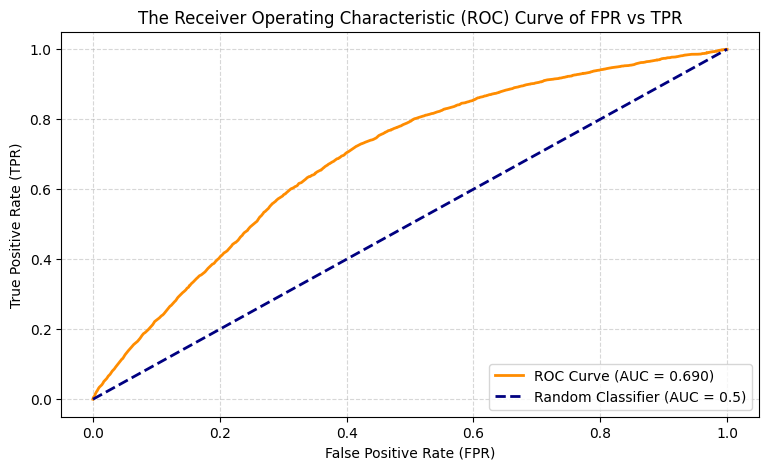

The AUC Score is: 0.6903


In [ ]:
# 1. Gathering predicted probabilities for the positive class "goal"
y_probas = clf.predict_proba(X_val)[:,1]

# 2. Computing the ROC curve
fpr, tpr, boundaries = roc_curve(y_val, y_probas)

# 3. Getting auc_score
auc_score = roc_auc_score(y_val, y_probas)

# 4. Plotting the ROC curve
plt.figure(figsize=(9,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
# 5. Setting The title
plt.title("The Receiver Operating Characteristic (ROC) Curve of FPR vs TPR")
# 6. Setting the x and y axis label
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
# 7. Plotting the legend
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
# 8. Plotting the graph
plt.show()

# 9. Printing the AUC score
print(f"The AUC Score is: {auc_score:.4f}")

**b) ii) Goal Rate by Predicted Probability Percentile**

/tmp/ipython-input-53249414.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean()


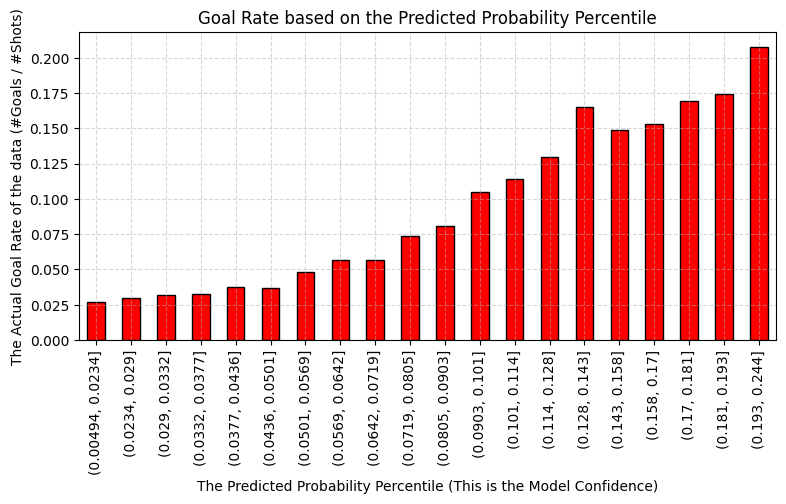

In [ ]:
# 1. Create a DataFrame that can be used for evaluation
df_evaluation = pd.DataFrame({
    "y_val": y_val,
    "y_probas": y_probas
})

# 2. Converting your bin predictions into percentiles and drop duplicates
df_evaluation["percentile_bin"] = pd.qcut(df_evaluation["y_probas"], q=20, duplicates="drop")

# 3. Computing the goal rate per percentile based on the mean y_val
rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean()

# 4. Plot goal rate as a function of model percentile
rate_of_goal.plot(kind='bar', figsize=(9,4), color='red', edgecolor='black')
# 5. Plotting the title, x and y axis along with grid
plt.title("Goal Rate based on the Predicted Probability Percentile")
plt.xlabel("The Predicted Probability Percentile (This is the Model Confidence)")
plt.ylabel("The Actual Goal Rate of the data (#Goals / #Shots)")
plt.grid(True, linestyle='--', alpha=0.5)
# 6. Plotting the graph
plt.show()

**b) iii) Cumulative Proportion of Goals by Model Probability**

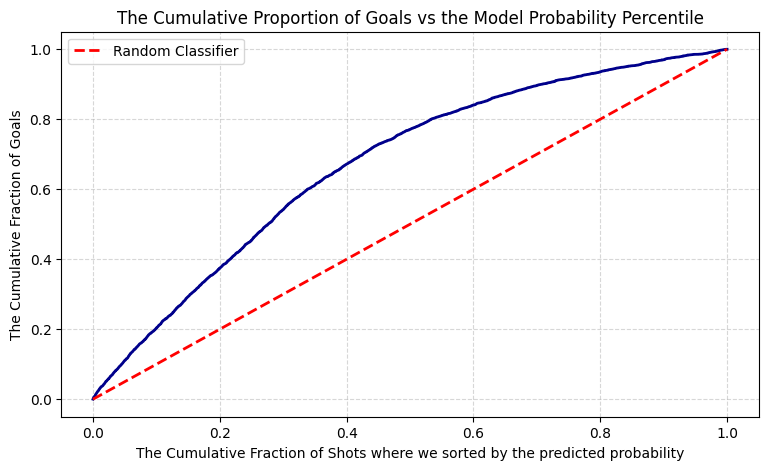

In [ ]:
# 1. We will first sort the df_eval by the predicted probability values
df_eval_sorted = df_evaluation.sort_values("y_probas", ascending=False)
# 2. Calculating cumulative goals
df_eval_sorted["cum_goals"] = df_eval_sorted["y_val"].cumsum()
# 3. Calculating fraction of cumulative goals
df_eval_sorted["fraction_cum_goals"] = df_eval_sorted["cum_goals"] / df_eval_sorted["y_val"].sum()
# 4. Calculating fraction of cumulative shots
df_eval_sorted["fraction_cum_shots"] = np.arange(len(df_eval_sorted)) / len(df_eval_sorted)

# 5. Plotting cumulative goals vs shots
plt.figure(figsize=(9,5))
plt.plot(df_eval_sorted["fraction_cum_shots"], df_eval_sorted["fraction_cum_goals"], color='darkblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2, label="Random Classifier")
# 6. Plottin the title, axis, and legend
plt.title("The Cumulative Proportion of Goals vs the Model Probability Percentile")
plt.xlabel("The Cumulative Fraction of Shots where we sorted by the predicted probability")
plt.ylabel("The Cumulative Fraction of Goals")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**b) iv) Reliability Diagram (The Calibration Curve)**

<Figure size 900x500 with 0 Axes>

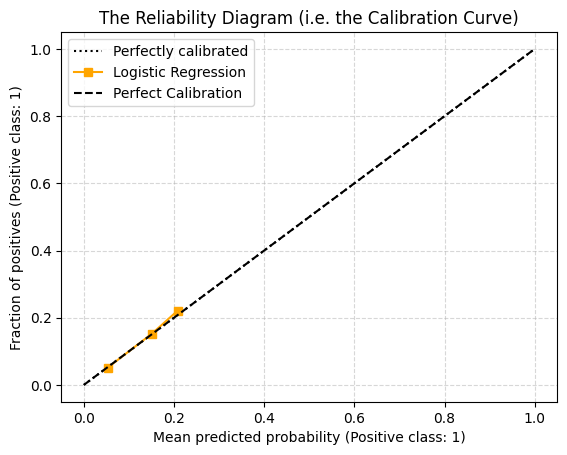

In [ ]:
from sklearn.calibration import CalibrationDisplay

# 1. Plotting figure and Calibration Display for Reliability diagram
plt.figure(figsize=(9,5))
CalibrationDisplay.from_estimator(
    clf, X_val, y_val, n_bins=10, name="Logistic Regression", color='orange'
)

# 2. Plotting the plot, title, grid, and legend
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfect Calibration")
plt.title("The Reliability Diagram (i.e. the Calibration Curve)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

**c) i) Training the Logistic Regression Model with more Features**

In [ ]:

# 1. Drop NAs from distance_from_net, angle_from_net, and is_goal column as Logistic Regression classifier cannot take NA values
tidy_shots_data = tidy_shots_data.dropna(subset=["distance_from_net", "angle_from_net", "is_goal"])

# 2. Defining the features and targets for your model
X_dist   = tidy_shots_data[["distance_from_net"]]
X_ang  = tidy_shots_data[["angle_from_net"]]
X_tog   = tidy_shots_data[["distance_from_net", "angle_from_net"]]
y        = tidy_shots_data["is_goal"]

# 2. Performing the Training and validation split for each model with train size being 0.8 and validation size being 0.2
X_train_d, X_val_d, y_train, y_val = train_test_split(X_dist, y, test_size=0.2, random_state=42, stratify=y)
X_train_ang, X_val_ang, _, _ = train_test_split(X_ang, y, test_size=0.2, random_state=42, stratify=y)
X_train_tog, X_val_tog, _, _ = train_test_split(X_tog, y, test_size=0.2, random_state=42, stratify=y)

# 3. Training the three logistic models
clf_dist  = LogisticRegression().fit(X_train_d, y_train)
clf_ang = LogisticRegression().fit(X_train_ang, y_train)
clf_tog  = LogisticRegression().fit(X_train_tog, y_train)

# 4. Caculating the predicted probabilities for the three models
y_prob_dist  = clf_dist.predict_proba(X_val_d)[:,1]
y_prob_ang = clf_ang.predict_proba(X_val_ang)[:,1]
y_prob_tog  = clf_tog.predict_proba(X_val_tog)[:,1]
y_prob_rand  = np.random.rand(len(y_val))  # Random baseline

NameError: name 'tidy_shots_data' is not defined

**c) ii) Plotting the ROC Curve across the 4 models**

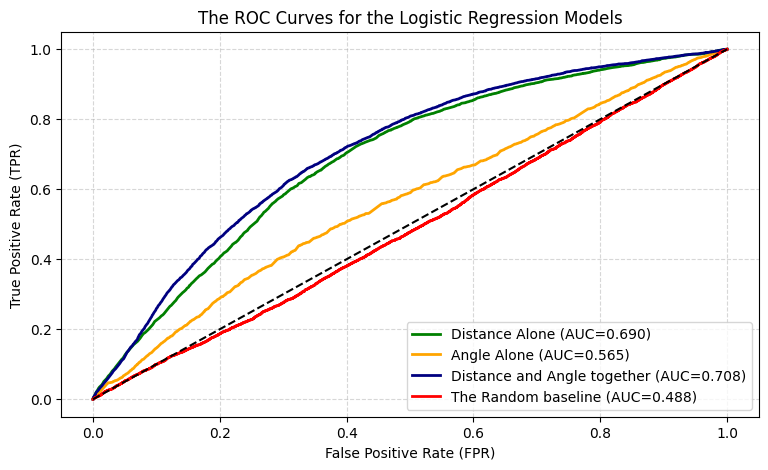

Angle Alone,▁
Distance Alone,▁
Distance and Angle together,▁
The Random baseline,▁
Angle Alone,0.56509
Distance Alone,0.69035
Distance and Angle together,0.70835
The Random baseline,0.48771


In [ ]:
# 1. Plotting the figure together
plt.figure(figsize=(9,5))

# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    # notes="commit message for the run",
    name="Logistic Regression AUC"
)

auc_logs = {}

# 2. Iterating y_prob and label over the various models
for y_prob, label, color in [
    (y_prob_dist,  "Distance Alone", "green"),
    (y_prob_ang, "Angle Alone",    "orange"),
    (y_prob_tog,  "Distance and Angle together", "navy"),
    (y_prob_rand,  "The Random baseline", "red"),
]:
# 3. Computing the false positive and true positive rate (fpr and tpr)
    fpr, tpr, _ = roc_curve(y_val, y_prob)

    # 4. Calculating the area under the curve
    auc = roc_auc_score(y_val, y_prob)
    auc_logs[label] = auc

    # 5. Plotting the false positive rate, true positive rate, etc
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", lw=2, color=color)

# 6. Plotting the ROC curves for the Logistic Regression Models
plt.plot([0,1],[0,1],'--',color='black')
# 7. Plotting the title, x and y labels, legend, and grid
plt.title("The ROC Curves for the Logistic Regression Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Log metrics
wandb.log(auc_logs)

# Create Artifact object
# joblib.dump(clf, 'logistic_regression_model.pkl')
# model_artifact = wandb.Artifact(name='logistic_regression_model', type='model')
# model_artifact.add_file('logistic_regression_model.pkl')
# wandb.log_artifact(model_artifact)

# Finish the run
wandb.finish()

**c) iii) Goal Rate sorted by Percentile Plot**

/tmp/ipython-input-600777974.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rates = prob_df.groupby("percentile")["y_true"].mean().values
/tmp/ipython-input-600777974.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rates = prob_df.groupby("percentile")["y_true"].mean().values
/tmp/ipython-input-600777974.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rates = prob_df.groupby("percentile")["y_t

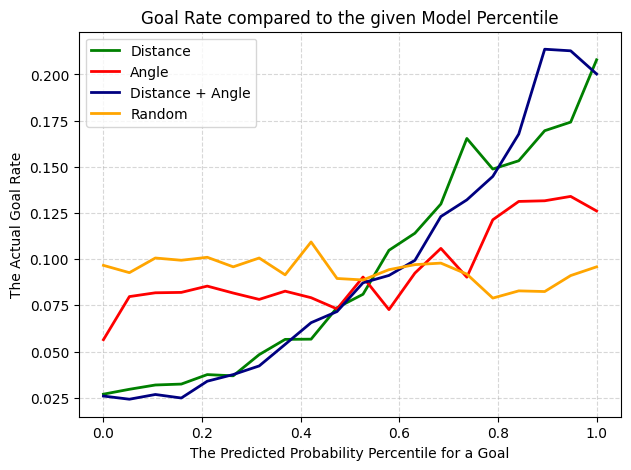

In [ ]:
# 1. Defining function for goal rate curve
def gr_curve(y_true, y_prob, label, color):
    prob_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
    prob_df["percentile"] = pd.qcut(prob_df["y_prob"], q=20, duplicates="drop")
    goal_rates = prob_df.groupby("percentile")["y_true"].mean().values
    plt.plot(np.linspace(0,1,len(goal_rates)), goal_rates, label=label, color=color, lw=2)

# 2. Defining goal rate curve for the various models
plt.figure(figsize=(7,5))
gr_curve(y_val, y_prob_dist,  "Distance", "green")
gr_curve(y_val, y_prob_ang, "Angle", "red")
gr_curve(y_val, y_prob_tog,  "Distance + Angle", "navy")
gr_curve(y_val, y_prob_rand,  "Random", "orange")
# 3. Defining title, x and y axis, legend, and grid
plt.title("Goal Rate compared to the given Model Percentile")
plt.xlabel("The Predicted Probability Percentile for a Goal")
plt.ylabel("The Actual Goal Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**c) iv) Defining The Cumulative Goals Curve**

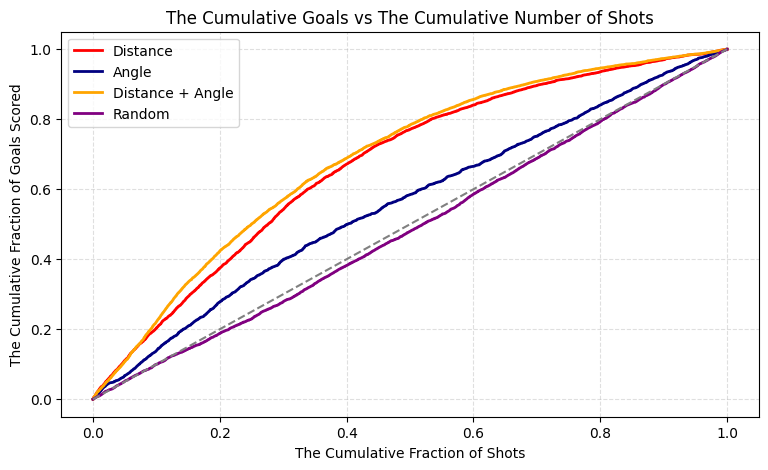

In [ ]:
# 1. Defining the cg (cumulative goals function)
def cg(y_true, y_prob, label, color):
    cg_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob}).sort_values("y_prob", ascending=False)
    cg_df["cum_goals"] = cg_df["y_true"].cumsum() / cg_df["y_true"].sum()
    cg_df["cum_shots"] = np.arange(len(cg_df)) / len(cg_df)
    plt.plot(cg_df["cum_shots"], cg_df["cum_goals"], label=label, color=color, lw=2)

# 2. Plotting the figure
plt.figure(figsize=(9,5))
# 3. Calling cg function on the four different feature combinations
cg(y_val, y_prob_dist,  "Distance", "red")
cg(y_val, y_prob_ang, "Angle", "navy")
cg(y_val, y_prob_tog,  "Distance + Angle", "orange")
cg(y_val, y_prob_rand,  "Random", "purple")
plt.plot([0,1],[0,1],'--',color='grey')
# 4. Plot title, labels, legend, and grid
plt.title("The Cumulative Goals vs The Cumulative Number of Shots")
plt.xlabel("The Cumulative Fraction of Shots")
plt.ylabel("The Cumulative Fraction of Goals Scored")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# **4. Feature Engineering II**

**a) Adding new Features**

In [ ]:
# 1. Start from your initial shots_df data set
df_shots = shots_df.copy()

# 2. Creating the Game Seconds column by breaking down and recombining the timeInPeriod column
# Specifically we convert time string "MM:SS" to total seconds
df_shots["game_seconds"] = df_shots["timeInPeriod"].apply(
    lambda time: int(time.split(":")[0]) * 60 + int(time.split(":")[1]) if isinstance(time, str) else np.nan
)

# 3. We can use existing columns and rename them to game period along with the x and y coordinates, also adding in game_id and game_seconds
df_shots["game_id"] = df_shots["id"]
df_shots["game_period"] = df_shots["periodDescriptor_number"]
df_shots["x_coord"] = df_shots["x_standardized"]
df_shots["y_coord"] = df_shots["y_standardized"]

# 4. Renaming columns to obtain shot distance, shot angle, and shot type
df_shots.rename(columns={
    "distance_from_net": "shot_distance",
    "angle_from_net": "shot_angle",
    "typeDescKey": "shot_type"
}, inplace=True)

# 5. Selecting final tidy dataset with all the required columns
tidy_data_updated = df_shots[["game_id",
    "game_seconds",
    "game_period",
    "x_coord", "y_coord",
    "shot_distance", "shot_angle",
    "shot_type",
    "is_goal", "empty_net"
]].copy()

# 6. Quick inspection
print(tidy_data_updated.head())
print(tidy_data_updated.columns)



       game_id  game_seconds  game_period  x_coord  y_coord  shot_distance  \
7   2016020001            71            1     77.0     -5.0      13.000000   
14  2016020001           173            1     86.0     13.0      13.341664   
21  2016020001           241            1     23.0    -38.0      76.157731   
23  2016020001           286            1     33.0    -15.0      57.974132   
36  2016020001           406            1     34.0    -28.0      61.717096   

    shot_angle     shot_type  is_goal  empty_net  
7    22.619865  shot-on-goal        0          0  
14   77.005383  shot-on-goal        0          0  
21   29.931512  shot-on-goal        0          0  
23   14.995079  shot-on-goal        0          0  
36   26.980231  shot-on-goal        0          0  
Index(['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord',
       'shot_distance', 'shot_angle', 'shot_type', 'is_goal', 'empty_net'],
      dtype='object')


**b) Adding Events to Shots**

In [ ]:
## Adding in Event related columns/features

# 1. Working with all events not exclusively shots
# 2. Making sure 'all_games_df' including every event with coordinates, time, and identifiers

all_games_df["game_id"] = all_games_df["id"]

events_df = all_games_df.copy().sort_values(by=["game_id", "eventId"]).reset_index(drop=True)

# 3. Computing the total game seconds (this would include the period time and the period offset time)
events_df["seconds_of_period"] = events_df["timeInPeriod"].apply(
    lambda t: int(t.split(":")[0]) * 60 + int(t.split(":")[1]) if isinstance(t, str) else np.nan
)
events_df["game_seconds"] = (events_df["periodDescriptor_number"] - 1) * 1200 + events_df["seconds_of_period"]

# 4. Obtain the immediately preceding event information for every NHL game
events_df["last_event_type"] = events_df.groupby("game_id")["typeDescKey"].shift(1)
events_df["last_event_x_coord"] = events_df.groupby("game_id")["details_xCoord"].shift(1)
events_df["last_event_y_coord"] = events_df.groupby("game_id")["details_yCoord"].shift(1)
events_df["last_event_time"] = events_df.groupby("game_id")["game_seconds"].shift(1)

# 5. Computing time since the last event
events_df["time_since_last_event"] = events_df["game_seconds"] - events_df["last_event_time"]
events_df["distance_from_last_event"] = np.sqrt(
    (events_df["details_xCoord"] - events_df["last_event_x_coord"])**2 +
    (events_df["details_yCoord"] - events_df["last_event_y_coord"])**2
)

# 6. Filtering events_df to only shot-related events, note this mirrors shots_df_updated
shots_with_prev = events_df[events_df["typeDescKey"].isin(["shot-on-goal", "goal"])].copy()

# 7. Keep only columns you need for merging
shots_with_prev_events = shots_with_prev[[
    "game_id", "game_seconds",
    "last_event_type", "last_event_x_coord", "last_event_y_coord",
    "time_since_last_event", "distance_from_last_event"
]]

# 8. Defining the columns that will be merged on
merge_cols = [
    "game_id", "game_seconds",
    "last_event_type", "last_event_x_coord", "last_event_y_coord",
    "time_since_last_event", "distance_from_last_event"
]

# 9. Before executing the merge, explicitly remove these columns from the tidy_data_updated if they already exist there to avoid duplicate column creation
tidy_data_updated = tidy_data_updated.drop(
    columns=[c for c in merge_cols if c in tidy_data_updated.columns and c not in ["game_id", "game_seconds"]],
    errors="ignore"
)

# 10. Perform the left merge between tidy_data_updated and shots_with_prev
tidy_data_updated = tidy_data_updated.merge(
    shots_with_prev[merge_cols],
    on=["game_id", "game_seconds"],
    how="left"
)

# 11. Confirming the merge worked and previewing the data
print("\n The Merge has completed safely with 0 redundant columns created.")
print(f" The tidy_data_updated now has these many: {len(tidy_data_updated.columns)} columns.")
print(list(tidy_data_updated.columns))
print("\n This is a preview of the new tidy update columns table: ")
print(tidy_data_updated.head())



 The Merge has completed safely with 0 redundant columns created.
 The tidy_data_updated now has these many: 15 columns.
['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord', 'shot_distance', 'shot_angle', 'shot_type', 'is_goal', 'empty_net', 'last_event_type', 'last_event_x_coord', 'last_event_y_coord', 'time_since_last_event', 'distance_from_last_event']

 This is a preview of the new tidy update columns table: 
      game_id  game_seconds  game_period  x_coord  y_coord  shot_distance  \
0  2016020001            71            1     77.0     -5.0      13.000000   
1  2016020001           173            1     86.0     13.0      13.341664   
2  2016020001           241            1     23.0    -38.0      76.157731   
3  2016020001           286            1     33.0    -15.0      57.974132   
4  2016020001           406            1     34.0    -28.0      61.717096   

   shot_angle     shot_type  is_goal  empty_net last_event_type  \
0   22.619865  shot-on-goal        0    

**c) Adding in Rebound, Change in shot angle, and speed**

In [ ]:
# Adding additional features including: Rebound, Change in Angle, and the Speed columns

# 1. Creating data frame of shots only feature including goals or shot-on-goal
shots_only_features = tidy_data_updated.copy()

# 2. Creating the rebound column which is true if the most recent event was a shot
shots_only_features["rebound"] = shots_only_features["last_event_type"].isin(["shot-on-goal", "goal"])

# 3. Creating the Shot Angle colum whereh shot is a rebound and otherwise set to 0
# Convert from radians to degrees
shots_only_features["change_in_shot_angle"] = np.where(
    shots_only_features["rebound"],
    np.abs(shots_only_features["shot_angle"] - np.arctan2(
        shots_only_features["y_coord"] - shots_only_features["last_event_y_coord"],
        shots_only_features["x_coord"] - shots_only_features["last_event_x_coord"]
    ) * 180 / np.pi),
    0
)

# 4. Creating the speed column divided with the formula distance from previous event/time from previous event)
# Consider possible divide by zero case
shots_only_features["speed"] = np.where(
    (shots_only_features["time_since_last_event"] > 0) & (~shots_only_features["time_since_last_event"].isna()),
    shots_only_features["distance_from_last_event"] / shots_only_features["time_since_last_event"],
    np.nan
)

# 5. Clean up extreme values (optional but good practice)
shots_only_features.loc[shots_only_features["speed"] > 1000, "speed"] = np.nan

# 6. View the resulting columns to make sure everything is added properly
print("\n Adding new columns to tidy_data including: rebound, change_in_shot_angle, and speed")
print(shots_only_features[[
    "game_id", "game_seconds", "shot_type",
    "last_event_type", "rebound", "change_in_shot_angle", "speed"
]].head(10))

# 7. Updating your main tidy dataset and make sure everything is correct
tidy_data_updated = shots_only_features

# 8. Previewing updated data set
print("\n These are the new columns of tidy_data_updated")
print(tidy_data_updated.head())

# 9. Seeing new columns created
print("\n These are the new columns of tidy_data_updated")
print(tidy_data_updated.columns)



 Adding new columns to tidy_data including: rebound, change_in_shot_angle, and speed
      game_id  game_seconds     shot_type last_event_type  rebound  \
0  2016020001            71  shot-on-goal         faceoff    False   
1  2016020001           173  shot-on-goal             hit    False   
2  2016020001           241  shot-on-goal         faceoff    False   
3  2016020001           286  shot-on-goal    shot-on-goal     True   
4  2016020001           406  shot-on-goal             hit    False   
5  2016020001           450  shot-on-goal    shot-on-goal     True   
6  2016020001           501          goal             hit    False   
7  2016020001           509  shot-on-goal         faceoff    False   
8  2016020001           540  shot-on-goal         faceoff    False   
9  2016020001           616  shot-on-goal         faceoff    False   

   change_in_shot_angle      speed  
0              0.000000   2.228870  
1              0.000000  14.944806  
2              0.000000   1.3880

**d) Bonus Section (Power Play Analysis)**

In [ ]:
# 1️. Analyze situation code to obtain Power Play Details (
power_play_df = all_games_df.copy()
power_play_df["game_id"] = power_play_df["id"]

# 2. Clean up situationCode safely before using extract_skaters
power_play_df["situationCode"] = (
    power_play_df["situationCode"]
    .astype(str)                       # convert everything to string
    .str.strip()                       # remove spaces around
    .str.replace(r"\.0$", "", regex=True)  # drop trailing .0 from floats
    .replace(["None", "nan", "NaN", "NULL", "NoneType"], np.nan)  # handle text NaNs
)

# 3. Keep only rows with purely numeric 3- or 4-digit codes
mask = power_play_df["situationCode"].str.match(r"^\d{3,4}$", na=False)
power_play_df = power_play_df[mask].copy()

# 4. Apply Extract Skaters column
def extract_skaters(code):
    code = str(int(code))
    if len(code) == 4:
        return int(code[1]), int(code[2])
    elif len(code) == 3:
        return int(code[0]), int(code[1])
    else:
        return np.nan, np.nan

pairs = [extract_skaters(c) for c in power_play_df["situationCode"]]
if pairs:
    home, away = zip(*pairs)
else:
    home, away = ([], [])

# 5. Define Home and Away skaters
power_play_df["home_skaters"] = home if len(home) else np.nan
power_play_df["away_skaters"] = away if len(away) else np.nan


# 6. Computing whether a power play is actually happening
invalid_codes = ["101", "560", "660"]
power_play_df["valid_power_play"] = (
    (power_play_df["home_skaters"] != power_play_df["away_skaters"]) &
    (~power_play_df["situationCode"].astype(str).isin(invalid_codes))
)

# 7. Now we identify which team is on the power play
power_play_df["power_play_team"] = np.where(
    power_play_df["home_skaters"] > power_play_df["away_skaters"], "home",
    np.where(power_play_df["away_skaters"] > power_play_df["home_skaters"], "away", None)
)

# 8. Computing the total game seconds, similar to the methods employed before (This is where we convert MM:SS to total seconds + add period offset)
power_play_df["seconds_in_period"] = power_play_df["timeInPeriod"].apply(
    lambda time: int(time.split(":")[0]) * 60 + int(time.split(":")[1]) if isinstance(time, str) else np.nan
)
power_play_df["game_seconds"] = (
    (power_play_df["periodDescriptor_number"] - 1) * 1200 + power_play_df["seconds_in_period"]
)

# 9. Sorting chronologically within each game in order to make the data set easier to read
power_play_df = power_play_df.sort_values(by=["id", "game_seconds"]).reset_index(drop=True)

# 10. Calculating the "time since power play started"
# Initially set it to 0
power_play_df["time_since_power_play_start"] = 0.0

# 11. Iterating through id and game events
for game_id, game_events in power_play_df.groupby("id"):
    last_pp_start_time = None
    times = []
    for _, r in game_events.iterrows():
        if r["valid_power_play"]:
            # 9. We first start the power play if power play is not already active
            if last_pp_start_time is None:
                last_pp_start_time = r["game_seconds"]
            times.append(r["game_seconds"] - last_pp_start_time)
        else:
            # 10. We reset timer when player returns to even strength
            last_pp_start_time = None
            times.append(0)
    power_play_df.loc[game_events.index, "time_since_power_play_start"] = times

# 12. Assigning the friendly and opposition's non-goalie skater counts in relation to each event's team
power_play_df["friendly_skaters"] = np.where(
    power_play_df["details_eventOwnerTeamId"] == power_play_df["homeTeam_id"],
    power_play_df["home_skaters"],
    power_play_df["away_skaters"]
)
power_play_df["opposing_skaters"] = np.where(
    power_play_df["details_eventOwnerTeamId"] == power_play_df["homeTeam_id"],
    power_play_df["away_skaters"],
    power_play_df["home_skaters"]
)

# 13. We select only the power play features for power_play_df we will use for merging
power_play_features = power_play_df[[
    "game_id",
    "game_seconds",
    "time_since_power_play_start",
    "friendly_skaters",
    "opposing_skaters"
]].drop_duplicates(subset=["game_id", "game_seconds"])


# 14. Before executing the merge, explicitly remove these columns from the tidy_data_updated if they already exist there to avoid duplicate column creation
tidy_data_updated = tidy_data_updated.drop(
    columns=[c for c in power_play_features if c in tidy_data_updated.columns and c not in ["game_id", "game_seconds"]],
    errors="ignore"
)

# 15. Perform the left merge between tidy_data_updated and shots_with_prev
tidy_data_updated = tidy_data_updated.merge(
    power_play_features,
    on=["game_id", "game_seconds"],
    how="left"
)

# 16. Removing the redundant 'id' column created during merge (if it exists) as it is irrelevant to the tidy data set as it has the game_id column
if "id" in tidy_data_updated.columns:
    tidy_data_updated.drop(columns=["id"], inplace=True)

# 17. Previewing the final tidy data frame with head
print("\n The Final tidy_data_updated after we combine the Power Play features is:")
print(tidy_data_updated.head())

# 18. Previewing the columns of tidy data updated
print("\n The Columns within the tidy_data_updated data now include:")
print(list(tidy_data_updated.columns))



 The Final tidy_data_updated after we combine the Power Play features is:
      game_id  game_seconds  game_period  x_coord  y_coord  shot_distance  \
0  2016020001            71            1     77.0     -5.0      13.000000   
1  2016020001           173            1     86.0     13.0      13.341664   
2  2016020001           241            1     23.0    -38.0      76.157731   
3  2016020001           286            1     33.0    -15.0      57.974132   
4  2016020001           406            1     34.0    -28.0      61.717096   

   shot_angle     shot_type  is_goal  empty_net  ... last_event_x_coord  \
0   22.619865  shot-on-goal        0          0  ...               69.0   
1   77.005383  shot-on-goal        0          0  ...              -93.0   
2   29.931512  shot-on-goal        0          0  ...               20.0   
3   14.995079  shot-on-goal        0          0  ...               23.0   
4   26.980231  shot-on-goal        0          0  ...               47.0   

   last_eve

In [ ]:
# Sanity check on friendly and opposing skaters
print("/n These are the value counts for friendly skater", tidy_data_updated["friendly_skaters"].value_counts())
print("/n These are the value counts for opposing skater", tidy_data_updated["opposing_skaters"].value_counts())

/n These are the value counts for friendly skater friendly_skaters
5.0    82362
4.0    12862
3.0      412
6.0       37
0.0        5
1.0        1
Name: count, dtype: int64
/n These are the value counts for opposing skater opposing_skaters
5.0    91830
4.0     3522
6.0      305
3.0       16
1.0        5
0.0        1
Name: count, dtype: int64


In [ ]:
# From Google import files
from google.colab import files
# Downloading tidy_data_updatd file
tidy_data_updated.to_csv("tidy_data_updated.csv", index=False)
# Download files
files.download("tidy_data_updated.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**e) Uploading the final dataframe with wandb**

In [ ]:
df = tidy_data_updated.loc[tidy_data_updated["game_id"] == 2017021065]

run = wandb.init(project="my_project")
# create a wandb Artifact for each meaningful step
artifact = wandb.Artifact(
    name="wpg_v_wsh_2017021065",
    type="dataset"
)
# add data
my_table = wandb.Table(dataframe=df)
artifact.add(my_table, "wpg_v_wsh_2017021065")
run.log_artifact(artifact)
run.finish()

# **5. Advanced Models**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_valid_df = all_games_df[all_games_df['season'].astype('str').between('2016','2019')]
test_final_df = all_games_df[all_games_df['season'].astype('str') == '2020']

# Further split train_valid_df into train and validation (e.g., 80/20 split)
train_df, valid_df = train_test_split(
    train_valid_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {valid_df.shape}")
print(f"Final test set shape: {test_final_df.shape}")

train_df.to_csv("train_data.csv", index=False)
valid_df.to_csv("validation_data.csv", index=False)
test_final_df.to_csv("test_data.csv", index=False)

Training set shape: (1025028, 28)
Validation set shape: (256258, 28)
Final test set shape: (0, 28)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np

train_df=pd.read_csv('/content/drive/MyDrive/Data Science Milestone 2/train_data.csv')
valid_df=pd.read_csv('/content/drive/MyDrive/Data Science Milestone 2/validation_data.csv')

In [ ]:
"""
Task 5: Advanced Models (XGBoost)
IFT 6758 - Milestone 2
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.calibration import CalibrationDisplay
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("="*70)
print("TASK 5: ADVANCED MODELS (XGBoost)")
print("="*70)

# ============================================================================
# STEP 1: LOAD AND PREPARE YOUR DATA
# ============================================================================
print("\n[STEP 1] Loading data...")

# UPDATE THESE PATHS TO YOUR FILES!
#train_df = pd.read_csv('train_data.csv')  # Change this path
#val_df = pd.read_csv('val_data.csv')      # Change this path

print(f"✓ Training set loaded: {train_df.shape}")
print(f"✓ Validation set loaded: {valid_df.shape}")

# Show first few columns
print(f"\nFirst 10 columns:")
for i, col in enumerate(train_df.columns[:10], 1):
    print(f"  {i}. {col}")

# ============================================================================
# STEP 2: FILTER SHOTS AND GOALS + COMPUTE DISTANCE/ANGLE
# ============================================================================
print("\n[STEP 2] Filtering shots/goals and computing features...")

def prepare_shot_data(df):
    """
    Prepare shot data by:
    1. Filtering to only shots and goals
    2. Standardizing coordinates
    3. Computing distance and angle from net
    4. Creating is_goal and empty_net features
    """
    print(f"  Original data shape: {df.shape}")

    # 1. Filter to shots and goals only
    shots_df = df[df['typeDescKey'].isin(['shot-on-goal', 'goal'])].copy()
    print(f"  After filtering shots/goals: {shots_df.shape}")

    # 2. Standardize coordinates (all shots facing same direction)
    shots_df['x_standardized'] = np.where(
        shots_df['details_xCoord'] < 0,
        -shots_df['details_xCoord'],
        shots_df['details_xCoord']
    )
    shots_df['y_standardized'] = np.where(
        shots_df['details_xCoord'] < 0,
        -shots_df['details_yCoord'],
        shots_df['details_yCoord']
    )

    # 3. Compute distance and angle from net
    def compute_angles_distance(x, y):
        x_net, y_net = 89, 0
        dx = x_net - x
        dy = y_net - y
        dist = np.sqrt(dx**2 + dy**2)
        ang = np.degrees(np.arctan2(abs(dy), abs(dx)))
        return dist, ang

    shots_df['distance_from_net'], shots_df['angle_from_net'] = zip(
        *shots_df.apply(
            lambda r: compute_angles_distance(r["x_standardized"], r["y_standardized"]),
            axis=1
        )
    )

    # 4. Create target variable (is_goal) and empty_net feature
    shots_df["is_goal"] = np.where(shots_df["typeDescKey"] == "goal", 1, 0)
    shots_df["empty_net"] = np.where(
        shots_df["details_goalieInNetId"].isna(), 1, 0
    )

    print(f"  Goal rate: {shots_df['is_goal'].mean():.3f}")
    print(f"  Empty net shots: {shots_df['empty_net'].sum()}")

    return shots_df

# Prepare train and validation data
print("\nPreparing training data...")
train_shots = prepare_shot_data(train_df)

print("\nPreparing validation data...")
val_shots = prepare_shot_data(valid_df)

print("\n✓ Data preparation complete!")

# ============================================================================
# STEP 3: DEFINE FEATURE SETS
# ============================================================================
print("\n[STEP 3] Defining feature sets...")

# Basic features (distance and angle only)
basic_features = ['distance_from_net', 'angle_from_net']

# All available features for Q2 and Q3
# Add more features here based on what's available in your data
all_features = [
    'distance_from_net',
    'angle_from_net',
    'x_standardized',
    'y_standardized',
    'empty_net'
]

# Check if other common features exist and add them
optional_features = [
    'details_shotType',
    'period',
    'timeInPeriod',
    'situationCode',
]

for feat in optional_features:
    if feat in train_shots.columns:
        all_features.append(feat)
        print(f"  ✓ Found optional feature: {feat}")

print(f"\nBasic features (Q1): {basic_features}")
print(f"All features (Q2, Q3): {len(all_features)} features")
print(f"  {all_features}")

target_col = 'is_goal'

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def prepare_features(df, feature_cols, target_col='is_goal'):
    """
    Prepare X and y from dataframe
    - Handles categorical variables with one-hot encoding
    - Fills missing values with 0
    """
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    if len(categorical_cols) > 0:
        print(f"  One-hot encoding {len(categorical_cols)} categorical columns: {categorical_cols}")
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Fill missing values
    if X.isnull().any().any():
        missing_count = X.isnull().sum().sum()
        if missing_count > 0:
            print(f"  Filling {missing_count} missing values with 0")
            X = X.fillna(0)

    # Ensure all columns are numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            print(f"  ⚠️  Converting {col} to numeric")
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

    return X, y


def compute_all_metrics(y_true, y_pred_proba):
    """
    Compute all required metrics:
    1. ROC curve and AUC
    2. Goal rate vs percentile
    3. Cumulative proportion of goals vs percentile
    """
    metrics = {}

    # 1. ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['auc'] = auc(fpr, tpr)

    # 2. Goal rate vs percentile
    percentiles = np.arange(0, 101, 5)
    percentile_values = np.percentile(y_pred_proba, percentiles)
    goal_rates = []

    for i in range(len(percentile_values)-1):
        mask = (y_pred_proba >= percentile_values[i]) & (y_pred_proba < percentile_values[i+1])
        if mask.sum() > 0:
            goal_rates.append(y_true[mask].mean())
        else:
            goal_rates.append(0)

    metrics['percentiles'] = percentiles[:-1]
    metrics['goal_rates'] = goal_rates

    # 3. Cumulative proportion of goals
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    sorted_goals = y_true.iloc[sorted_indices] if isinstance(y_true, pd.Series) else y_true[sorted_indices]
    cumsum_goals = np.cumsum(sorted_goals)
    total_goals = sorted_goals.sum()
    cum_prop = cumsum_goals / total_goals if total_goals > 0 else cumsum_goals

    metrics['cum_percentiles'] = np.linspace(0, 100, len(cum_prop))
    metrics['cum_prop_goals'] = cum_prop

    return metrics


def save_model_info(model, metrics, filename_prefix):
    """Save model and its performance metrics"""
    model_file = f"{filename_prefix}_model.pkl"
    joblib.dump(model, model_file)

    metrics_file = f"{filename_prefix}_metrics.pkl"
    joblib.dump(metrics, metrics_file)

    print(f"  ✓ Saved: {model_file}")
    print(f"  ✓ Saved: {metrics_file}")

    return model_file, metrics_file


TASK 5: ADVANCED MODELS (XGBoost)

[STEP 1] Loading data...
✓ Training set loaded: (1025028, 28)
✓ Validation set loaded: (256258, 28)

First 10 columns:
  1. id
  2. season
  3. gameDate
  4. homeTeam_id
  5. homeTeam_abbrev
  6. homeTeam_commonName_default
  7. awayTeam_id
  8. awayTeam_abbrev
  9. awayTeam_commonName_default
  10. eventId

[STEP 2] Filtering shots/goals and computing features...

Preparing training data...
  Original data shape: (1025028, 28)
  After filtering shots/goals: (202642, 28)
  Goal rate: 0.094
  Empty net shots: 913

Preparing validation data...
  Original data shape: (256258, 28)
  After filtering shots/goals: (50833, 28)
  Goal rate: 0.095
  Empty net shots: 227

✓ Data preparation complete!

[STEP 3] Defining feature sets...
  ✓ Found optional feature: details_shotType
  ✓ Found optional feature: timeInPeriod
  ✓ Found optional feature: situationCode

Basic features (Q1): ['distance_from_net', 'angle_from_net']
All features (Q2, Q3): 8 features
  ['dis

Training data shape: (1025028, 28)
Validation data shape: (256258, 28)
Prepared training shots: (202642, 34)
Prepared validation shots: (50833, 34)

Training features: (202642, 2)
Validation features: (50833, 2)
✓ XGBoost training complete

Validation Accuracy: 0.9054
Validation AUC: 0.7056


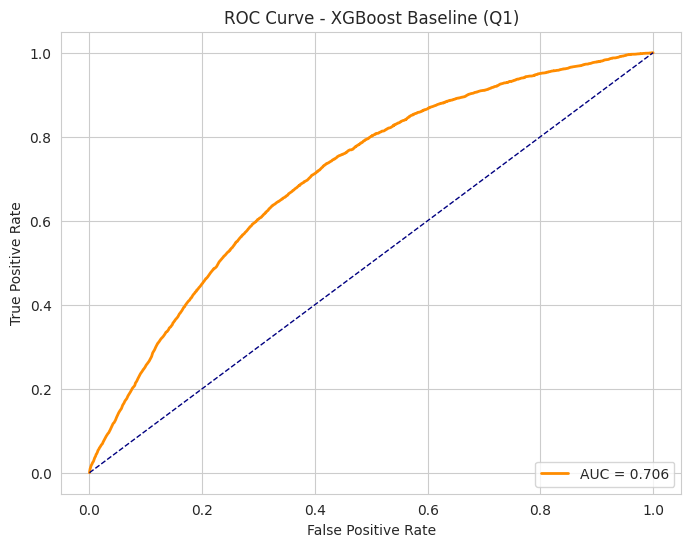

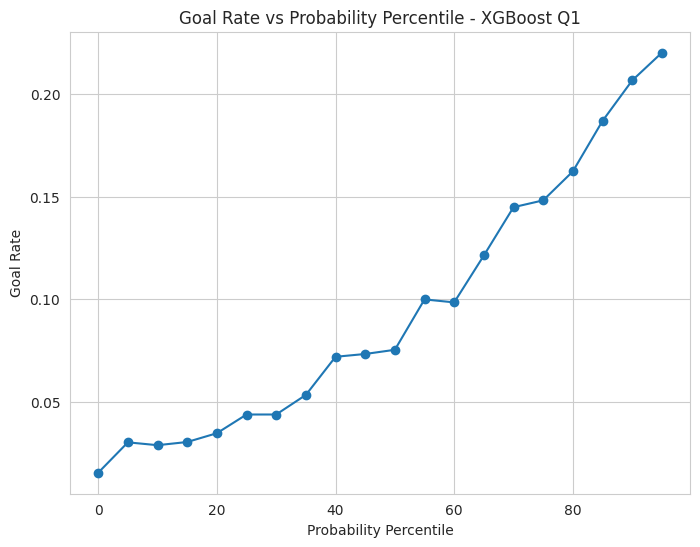

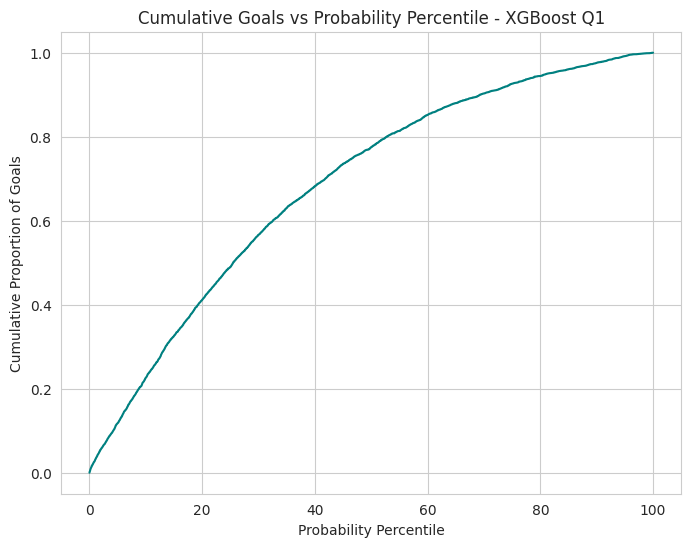

<Figure size 800x600 with 0 Axes>

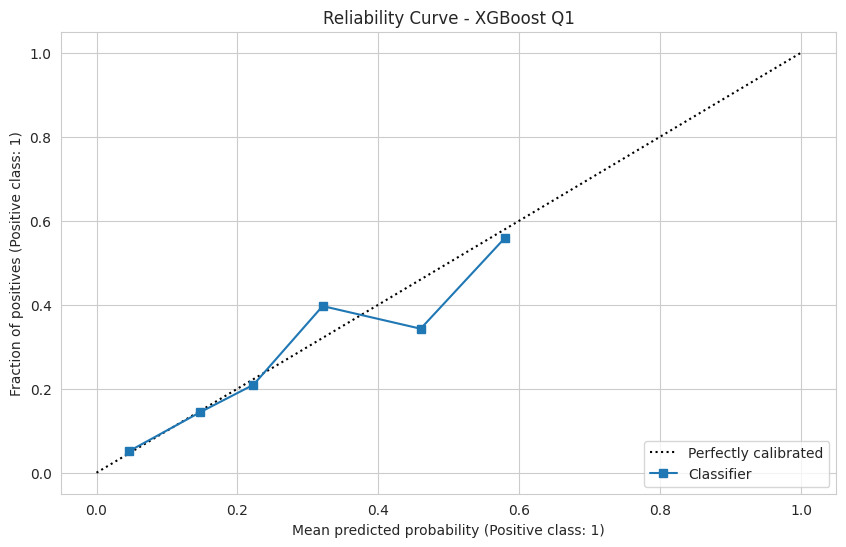


✓ Model saved as q1_xgb_baseline_model.pkl
✓ Plots saved: ROC, Goal Rate, Cumulative Goals, Reliability Curve


In [ ]:
# ===============================================================
# IFT 6758 - Milestone 2
# Task 5: Advanced Models - QUESTION 1
# XGBoost Baseline (Distance & Angle Only)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score
)
from sklearn.calibration import CalibrationDisplay
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 1. Load Data
# ----------------------------
#train_df = pd.read_csv('/content/train_data.csv')
#valid_df = pd.read_csv('/content/validation_data.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {valid_df.shape}")

# ----------------------------
# 2. Prepare Shot Data
# ----------------------------
def prepare_shot_data(df):
    """Filter to shots/goals and compute distance, angle, and target features."""
    shots_df = df[df['typeDescKey'].isin(['shot-on-goal', 'goal'])].copy()

    # Standardize coordinates (all shots face the same net)
    shots_df['x_standardized'] = np.where(
        shots_df['details_xCoord'] < 0,
        -shots_df['details_xCoord'],
        shots_df['details_xCoord']
    )
    shots_df['y_standardized'] = np.where(
        shots_df['details_xCoord'] < 0,
        -shots_df['details_yCoord'],
        shots_df['details_yCoord']
    )

    # Compute distance and angle from the net (net at x=89, y=0)
    def compute_angles_distance(x, y):
        x_net, y_net = 89, 0
        dx = x_net - x
        dy = y_net - y
        dist = np.sqrt(dx**2 + dy**2)
        ang = np.degrees(np.arctan2(abs(dy), abs(dx)))
        return dist, ang

    shots_df['distance_from_net'], shots_df['angle_from_net'] = zip(
        *shots_df.apply(lambda r: compute_angles_distance(r["x_standardized"], r["y_standardized"]), axis=1)
    )

    # Target variable
    shots_df['is_goal'] = np.where(shots_df['typeDescKey'] == 'goal', 1, 0)
    shots_df['empty_net'] = np.where(shots_df['details_goalieInNetId'].isna(), 1, 0)

    return shots_df

train_shots = prepare_shot_data(train_df)
valid_shots = prepare_shot_data(valid_df)

print(f"Prepared training shots: {train_shots.shape}")
print(f"Prepared validation shots: {valid_shots.shape}")

# ----------------------------
# 3. Define Features and Target
# ----------------------------
features = ['distance_from_net', 'angle_from_net']
target = 'is_goal'

X_train = train_shots[features]
y_train = train_shots[target]
X_valid = valid_shots[features]
y_valid = valid_shots[target]

print(f"\nTraining features: {X_train.shape}")
print(f"Validation features: {X_valid.shape}")

# ----------------------------
# 4. Train XGBoost Model (Baseline)
# ----------------------------
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)
print("✓ XGBoost training complete")

# ----------------------------
# 5. Evaluate Model
# ----------------------------
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

accuracy = accuracy_score(y_valid, y_pred)
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Validation AUC: {roc_auc:.4f}")

# ----------------------------
# 6. Compute Goal Rate & Cumulative Metrics
# ----------------------------
percentiles = np.arange(0, 101, 5)
thresholds = np.percentile(y_pred_proba, percentiles)
goal_rates = []
for i in range(len(thresholds) - 1):
    mask = (y_pred_proba >= thresholds[i]) & (y_pred_proba < thresholds[i+1])
    goal_rates.append(y_valid[mask].mean() if mask.sum() > 0 else 0)

sorted_idx = np.argsort(y_pred_proba)[::-1]
sorted_goals = y_valid.iloc[sorted_idx]
cumsum_goals = np.cumsum(sorted_goals)
total_goals = sorted_goals.sum()
cum_prop = cumsum_goals / total_goals
cum_percentiles = np.linspace(0, 100, len(cum_prop))

# ----------------------------
# 7. PLOTS (All Four Figures)
# ----------------------------

# (1) ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Baseline (Q1)")
plt.legend(loc="lower right")
plt.savefig("q1_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# (2) Goal Rate vs Probability Percentile
plt.figure(figsize=(8, 6))
plt.plot(percentiles[:-1], goal_rates, marker='o')
plt.xlabel("Probability Percentile")
plt.ylabel("Goal Rate")
plt.title("Goal Rate vs Probability Percentile - XGBoost Q1")
plt.savefig("q1_goal_rate_vs_percentile.png", dpi=300, bbox_inches='tight')
plt.show()

# (3) Cumulative Proportion of Goals vs Probability Percentile
plt.figure(figsize=(8, 6))
plt.plot(cum_percentiles, cum_prop, color='teal')
plt.xlabel("Probability Percentile")
plt.ylabel("Cumulative Proportion of Goals")
plt.title("Cumulative Goals vs Probability Percentile - XGBoost Q1")
plt.savefig("q1_cumulative_goals.png", dpi=300, bbox_inches='tight')
plt.show()

# (4) Reliability Curve
plt.figure(figsize=(8, 6))
CalibrationDisplay.from_predictions(y_valid, y_pred_proba, n_bins=10)
plt.title("Reliability Curve - XGBoost Q1")
plt.savefig("q1_reliability_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 8. Save Model
# ----------------------------
joblib.dump(model, "q1_xgb_baseline_model.pkl")
print("\n✓ Model saved as q1_xgb_baseline_model.pkl")
print("✓ Plots saved: ROC, Goal Rate, Cumulative Goals, Reliability Curve")


In [ ]:


# ============================================================================
# QUESTION 1: XGBoost Baseline (Distance & Angle only)
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: XGBoost Baseline (Distance & Angle Only)")
print("="*70)

print(f"\nUsing features: {basic_features}")

# Prepare data
print("\nPreparing data for Q1...")
X_train_q1, y_train_q1 = prepare_features(train_shots, basic_features, target_col)
X_val_q1, y_val_q1 = prepare_features(val_shots, basic_features, target_col)

print(f"Training features shape: {X_train_q1.shape}")
print(f"Validation features shape: {X_val_q1.shape}")

# Train model with default parameters
print("\nTraining XGBoost with default parameters...")
model_q1 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model_q1.fit(X_train_q1, y_train_q1)
print("✓ Training complete")

# Evaluate
print("\nEvaluating on validation set...")
y_pred_q1 = model_q1.predict(X_val_q1)
y_pred_proba_q1 = model_q1.predict_proba(X_val_q1)[:, 1]

accuracy_q1 = accuracy_score(y_val_q1, y_pred_q1)
metrics_q1 = compute_all_metrics(y_val_q1, y_pred_proba_q1)

print(f"✓ Validation Accuracy: {accuracy_q1:.4f}")
print(f"✓ Validation AUC: {metrics_q1['auc']:.4f}")

# Save model
print("\nSaving model...")
save_model_info(model_q1, metrics_q1, "q1_xgb_baseline")

print("\n" + "-"*70)
print("Q1 COMPLETE!")
print("-"*70)


QUESTION 1: XGBoost Baseline (Distance & Angle Only)

Using features: ['distance_from_net', 'angle_from_net']

Preparing data for Q1...
  Filling 24 missing values with 0
  Filling 8 missing values with 0
Training features shape: (202642, 2)
Validation features shape: (50833, 2)

Training XGBoost with default parameters...
✓ Training complete

Evaluating on validation set...
✓ Validation Accuracy: 0.9053
✓ Validation AUC: 0.7053

Saving model...
  ✓ Saved: q1_xgb_baseline_model.pkl
  ✓ Saved: q1_xgb_baseline_metrics.pkl

----------------------------------------------------------------------
Q1 COMPLETE!
----------------------------------------------------------------------


Training data shape: (1025028, 28)
Validation data shape: (256258, 28)

Starting FAST GridSearchCV...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
✓ Grid search complete!

Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best CV AUC: 0.7578

Validation Accuracy: 0.9098
Validation AUC: 0.7509


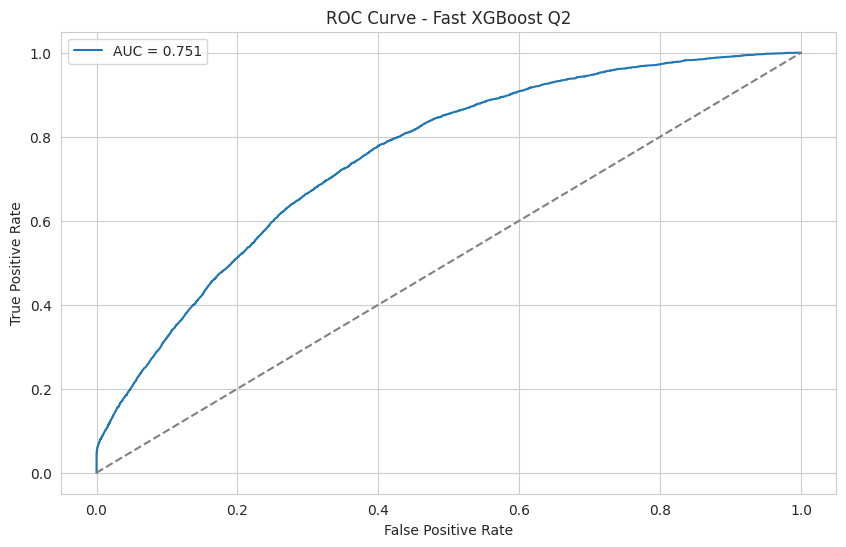


✓ Fast model and best params saved.


In [ ]:
# ===============================================================
# IFT 6758 - Milestone 2
# Task 5: Advanced Models - QUESTION 2 (FAST VERSION)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.calibration import CalibrationDisplay
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ----------------------------
# 1. Load Data
# ----------------------------
# train_df = pd.read_csv("/content/train_data.csv")
# valid_df = pd.read_csv("/content/validation_data.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {valid_df.shape}")

# ----------------------------
# 2. Prepare Shot Data
# ----------------------------
def prepare_shot_data(df):
    shots_df = df[df["typeDescKey"].isin(["shot-on-goal", "goal"])].copy()

    shots_df["x_standardized"] = np.where(
        shots_df["details_xCoord"] < 0,
        -shots_df["details_xCoord"],
        shots_df["details_xCoord"],
    )
    shots_df["y_standardized"] = np.where(
        shots_df["details_xCoord"] < 0,
        -shots_df["details_yCoord"],
        shots_df["details_yCoord"],
    )

    def compute_angles_distance(x, y):
        x_net, y_net = 89, 0
        dx = x_net - x
        dy = y_net - y
        dist = np.sqrt(dx**2 + dy**2)
        ang = np.degrees(np.arctan2(abs(dy), abs(dx)))
        return dist, ang

    shots_df["distance_from_net"], shots_df["angle_from_net"] = zip(
        *shots_df.apply(lambda r: compute_angles_distance(r["x_standardized"], r["y_standardized"]), axis=1)
    )

    shots_df["is_goal"] = np.where(shots_df["typeDescKey"] == "goal", 1, 0)
    shots_df["empty_net"] = np.where(shots_df["details_goalieInNetId"].isna(), 1, 0)
    return shots_df


train_shots = prepare_shot_data(train_df)
valid_shots = prepare_shot_data(valid_df)

# ----------------------------
# 3. Define Features & Target
# ----------------------------
base_features = ["distance_from_net", "angle_from_net"]
additional_features = [
    "x_standardized",
    "y_standardized",
    "empty_net",
    "details_shotType",
    "period",
    "timeInPeriod",
    "situationCode",
]
all_features = base_features + [f for f in additional_features if f in train_shots.columns]
target = "is_goal"

# ----------------------------
# 4. Prepare Data
# ----------------------------
def prepare_features(df, feature_cols, target_col="is_goal", ref_columns=None):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns

    if len(cat_cols) > 0:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Align columns with training reference if provided
    if ref_columns is not None:
        for col in ref_columns:
            if col not in X.columns:
                X[col] = 0  # add missing columns
        X = X[ref_columns]  # reorder columns

    return X.fillna(0), y


# Prepare training data
X_train, y_train = prepare_features(train_shots, all_features)

# Prepare validation data (align columns with train)
X_val, y_val = prepare_features(valid_shots, all_features, ref_columns=X_train.columns)


# ----------------------------
# 5. FAST Grid Search
# ----------------------------
# ⚡ Shrink grid drastically — only key combinations
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [1],
}

grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False, tree_method="hist"),
    param_grid,
    cv=2,  # ⚡ Only 2 folds instead of 3
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

print("\nStarting FAST GridSearchCV...")
grid_search.fit(X_train, y_train)
print("✓ Grid search complete!")

print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# ----------------------------
# 6. Evaluate on Validation Set
# ----------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

print(f"\nValidation Accuracy: {acc:.4f}")
print(f"Validation AUC: {roc_auc:.4f}")

# ----------------------------
# 7. Visualizations
# ----------------------------
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fast XGBoost Q2")
plt.legend()
plt.show()

# ----------------------------
# 8. Save
# ----------------------------
joblib.dump(best_model, "q2_fast_xgb_model.pkl")
joblib.dump(grid_search.best_params_, "q2_fast_best_params.pkl")
print("\n✓ Fast model and best params saved.")


Loaded Q2 model ✅
Train shape: (202642, 1212), Val shape: (50833, 1212)
Q2 AUC (all features): 0.7509


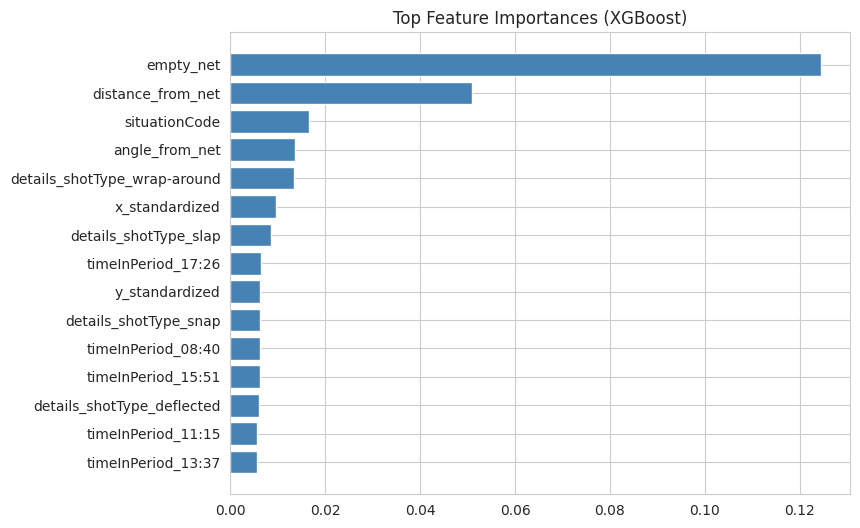

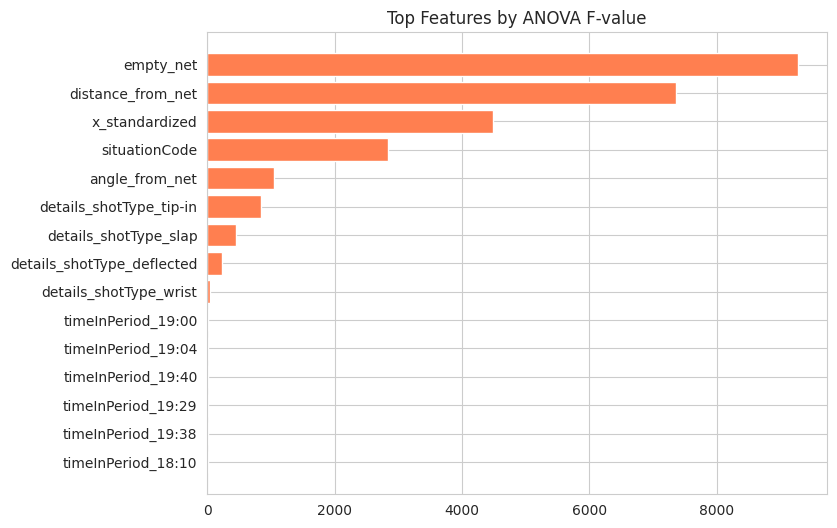

Selected 23 consensus features ✅
Q3 AUC (selected features): 0.7534


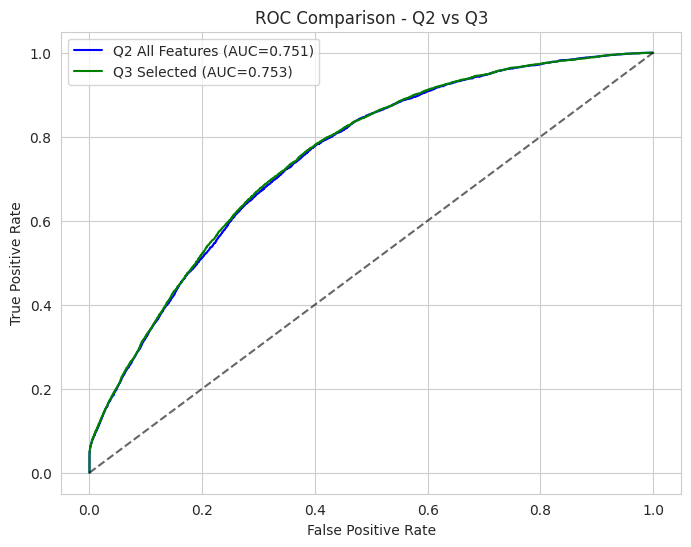

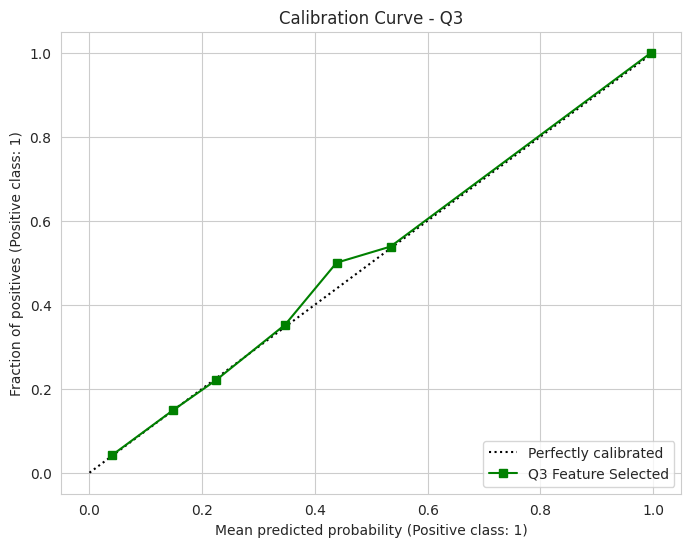

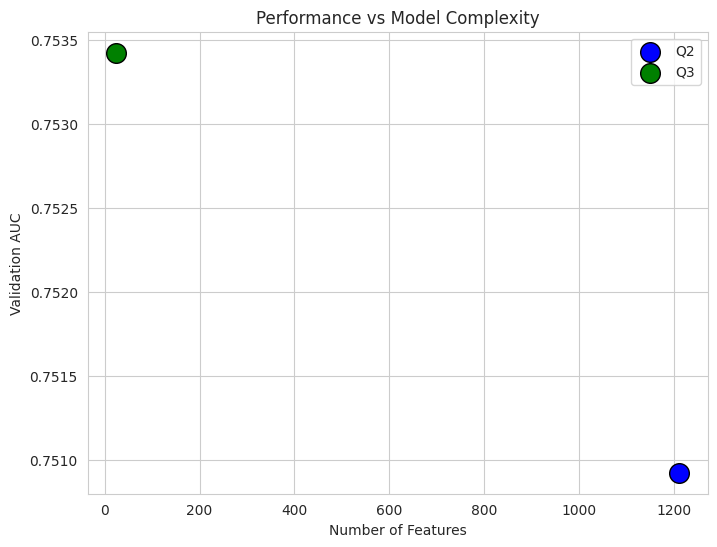


Performance Comparison:
AUC (Q2 - All): 0.7509
AUC (Q3 - Selected): 0.7534
Features reduced from 1212 → 23 (98.1% reduction)


In [ ]:
"""
Task 5 - Question 3: Feature Selection (Clean Version)
IFT 6758 - Milestone 2
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.calibration import CalibrationDisplay
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# -------------------------------------------------------------------------
# Load Q2 model
# -------------------------------------------------------------------------
best_model_q2 = joblib.load("/content/q2_fast_xgb_model.pkl")
best_params_q2 = joblib.load("/content/q2_fast_best_params.pkl")

print(f"Loaded Q2 model ✅")
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")

# Baseline AUC
y_pred_proba_q2 = best_model_q2.predict_proba(X_val)[:, 1]
fpr_q2, tpr_q2, _ = roc_curve(y_val, y_pred_proba_q2)
auc_q2 = auc(fpr_q2, tpr_q2)
print(f"Q2 AUC (all features): {auc_q2:.4f}")

# -------------------------------------------------------------------------
# Feature selection methods
# -------------------------------------------------------------------------

# 1️⃣ XGBoost Importance
feature_importances = best_model_q2.feature_importances_
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
importances_df = importances_df.sort_values('importance', ascending=False)
top_xgb_features = set(importances_df.head(15)['feature'])

plt.barh(importances_df.head(15)['feature'], importances_df.head(15)['importance'], color='steelblue')
plt.title("Top Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

# 2️⃣ ANOVA F-value
selector_kbest = SelectKBest(f_classif, k='all')
selector_kbest.fit(X_train, y_train)
f_scores_df = pd.DataFrame({'feature': X_train.columns, 'f_score': selector_kbest.scores_}).sort_values('f_score', ascending=False)
top_f_features_set = set(f_scores_df.head(15)['feature'])

plt.barh(f_scores_df.head(15)['feature'], f_scores_df.head(15)['f_score'], color='coral')
plt.title("Top Features by ANOVA F-value")
plt.gca().invert_yaxis()
plt.show()

# 3️⃣ L1 Regularization
l1_model = xgb.XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.1, reg_alpha=1.0,
    random_state=42, eval_metric='logloss', use_label_encoder=False
)
l1_model.fit(X_train, y_train, verbose=False)
selector_l1 = SelectFromModel(l1_model, prefit=True, threshold='median')
l1_selected_features = X_train.columns[selector_l1.get_support()]
top_l1_features_set = set(l1_selected_features)

# -------------------------------------------------------------------------
# Combine Methods
# -------------------------------------------------------------------------
consensus_features = (
    (top_xgb_features & top_f_features_set)
    | (top_xgb_features & top_l1_features_set)
    | (top_f_features_set & top_l1_features_set)
)
optimal_features = list(consensus_features)

print(f"Selected {len(optimal_features)} consensus features ✅")

# -------------------------------------------------------------------------
# Train with selected features
# -------------------------------------------------------------------------
X_train_sel = X_train[optimal_features]
X_val_sel = X_val[optimal_features]

model_q3 = xgb.XGBClassifier(**best_params_q2, random_state=42, eval_metric='logloss', use_label_encoder=False)
model_q3.fit(X_train_sel, y_train)

y_pred_proba_q3 = model_q3.predict_proba(X_val_sel)[:, 1]
fpr_q3, tpr_q3, _ = roc_curve(y_val, y_pred_proba_q3)
auc_q3 = auc(fpr_q3, tpr_q3)

print(f"Q3 AUC (selected features): {auc_q3:.4f}")

# -------------------------------------------------------------------------
# Plots (show instead of save)
# -------------------------------------------------------------------------

# ROC Comparison
plt.plot(fpr_q2, tpr_q2, label=f"Q2 All Features (AUC={auc_q2:.3f})", color="blue")
plt.plot(fpr_q3, tpr_q3, label=f"Q3 Selected (AUC={auc_q3:.3f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison - Q2 vs Q3")
plt.legend()
plt.show()

# Calibration Curve
CalibrationDisplay.from_estimator(model_q3, X_val_sel, y_val, n_bins=10, name='Q3 Feature Selected', color='green')
plt.title("Calibration Curve - Q3")
plt.show()

# Performance vs Complexity
plt.scatter(X_train.shape[1], auc_q2, s=200, color='blue', edgecolor='black', label='Q2')
plt.scatter(len(optimal_features), auc_q3, s=200, color='green', edgecolor='black', label='Q3')
plt.xlabel("Number of Features")
plt.ylabel("Validation AUC")
plt.title("Performance vs Model Complexity")
plt.legend()
plt.show()

# -------------------------------------------------------------------------
# Summary
# -------------------------------------------------------------------------
print(f"\nPerformance Comparison:")
print(f"AUC (Q2 - All): {auc_q2:.4f}")
print(f"AUC (Q3 - Selected): {auc_q3:.4f}")
print(f"Features reduced from {X_train.shape[1]} → {len(optimal_features)} ({100*(1-len(optimal_features)/X_train.shape[1]):.1f}% reduction)")


#**6. Give it your best shot!**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn

# Making a small dataset to make code execution faster
try:
  df = tidy_data_updated
except:
  df = pd.read_csv("tidy_data_updated.csv")
df.head()

,game_id,game_seconds,game_period,x_coord,y_coord,shot_distance,shot_angle,shot_type,is_goal,empty_net,...,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,change_in_shot_angle,speed,time_since_power_play_start,friendly_skaters,opposing_skaters
0,2016020001,71,1,77.0,-5.0,13.000000,22.619865,shot-on-goal,0,0,...,69.0,23.0,66.0,147.105404,False,0.000000,2.228870,0.0,5.0,5.0
1,2016020001,173,1,86.0,13.0,13.341664,77.005383,shot-on-goal,0,0,...,-93.0,24.0,12.0,179.337670,False,0.000000,14.944806,0.0,5.0,5.0
2,2016020001,241,1,23.0,-38.0,76.157731,29.931512,shot-on-goal,0,0,...,20.0,23.0,44.0,61.073726,False,0.000000,1.388039,0.0,5.0,5.0
3,2016020001,286,1,33.0,-15.0,57.974132,14.995079,shot-on-goal,0,0,...,23.0,-38.0,45.0,25.079872,True,51.506355,0.557330,0.0,5.0,5.0
4,2016020001,406,1,34.0,-28.0,61.717096,26.980231,shot-on-goal,0,0,...,47.0,34.0,16.0,81.221918,False,0.000000,5.076370,0.0,5.0,5.0


### Preprocessing

In [ ]:
def handle_missing_values(df_input):
    df = df_input.copy()

    print(f"Missing values before handling: {df.isna().sum().sum()}")
    # Numerical columns with few missing values: remove them
    numerical_cols_remove = [
        'x_coord', 'y_coord', 'shot_distance', 'shot_angle', 'change_in_shot_angle'
    ]
    for col in numerical_cols_remove:
      df.dropna(subset=numerical_cols_remove, inplace=True)

    # Categorical column 'last_event_type': fill with 'unknown'
    df['last_event_type'] = df['last_event_type'].fillna('unknown')

    # Numerical columns with many missing values (indicating absence): fill with 0
    numerical_cols_zero = [
        'last_event_x_coord', 'last_event_y_coord', 'time_since_last_event',
        'distance_from_last_event', 'speed', 'time_since_power_play_start',
        'friendly_skaters', 'opposing_skaters'
    ]

    for col in numerical_cols_zero:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    print(f"Missing values after handling: {df.isna().sum().sum()}")
    return df

# Apply the function to your DataFrame
df_cleaned = handle_missing_values(df)

# Apply one-hot encoding to 'shot_type' and 'last_event_type'
df_encoded = pd.get_dummies(df_cleaned, columns=['shot_type', 'last_event_type'], drop_first=True)

X = df_encoded.drop(columns=['is_goal'])
y = df_encoded['is_goal']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Missing values before handling: 1497345
Missing values after handling: 0


KeyboardInterrupt: 

## Testing different models

### Logistic regression

In [ ]:
logreg = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "class_weight": [None, "balanced"],
    "solver": ["lbfgs", "newton-cholesky"],
}

grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_logreg.fit(X_train_scaled, y_train)

print("Best params:", grid_logreg.best_params_)
print("Best CV AUC:", grid_logreg.best_score_)

best_logreg = grid_logreg.best_estimator_

y_proba_test = best_logreg.predict_proba(X_valid_scaled)[:, 1]
test_auc = roc_auc_score(y_valid, y_proba_test)

print("Test AUC:", test_auc)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV AUC: 1.0
Test AUC: 1.0


### XGBoost

In [ ]:
xgb = XGBClassifier(
    tree_method="hist",
    random_state=42
)

param_grid_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "eval_metric": ["logloss", "auc"]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_scaled, y_train)
print("XGB best params:", grid_xgb.best_params_)
print("XGB best CV AUC:", grid_xgb.best_score_)

# Test set AUC
best_xgb = grid_xgb.best_estimator_

y_proba_test = best_xgb.predict_proba(X_valid_scaled)[:, 1]
test_auc = roc_auc_score(y_valid, y_proba_test)

print("Test AUC:", test_auc)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
XGB best params: {'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGB best CV AUC: 1.0
Test AUC: 1.0


### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 3, 5],
    "min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_scaled, y_train)
print("RF best params:", grid_rf.best_params_)
print("RF best CV AUC:", grid_rf.best_score_)

# Test set AUC
best_rf = grid_rf.best_estimator_

y_proba_test = best_rf.predict_proba(X_valid_scaled)[:, 1]
test_auc = roc_auc_score(y_valid, y_proba_test)

print("Test AUC:", test_auc)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
RF best CV AUC: 1.0
Test AUC: 1.0


### Neural Networks

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert NumPy arrays and Pandas Series to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Helper function for calculating accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=X_train_tensor.shape[1], out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = Model1().to(device)

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train_tensor.to(device), y_train_tensor.to(device)
X_test, y_test = X_valid_tensor.to(device), y_valid_tensor.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_1(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test)
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.66632, Accuracy: 88.65% | Test Loss: 0.64768, Test Accuracy: 89.79%
Epoch: 100 | Loss: 0.11503, Accuracy: 90.94% | Test Loss: 0.11217, Test Accuracy: 91.11%
Epoch: 200 | Loss: 0.01242, Accuracy: 99.98% | Test Loss: 0.01195, Test Accuracy: 99.99%
Epoch: 300 | Loss: 0.00486, Accuracy: 100.00% | Test Loss: 0.00471, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00277, Accuracy: 100.00% | Test Loss: 0.00272, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00187, Accuracy: 100.00% | Test Loss: 0.00185, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.00139, Accuracy: 100.00% | Test Loss: 0.00138, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.00109, Accuracy: 100.00% | Test Loss: 0.00108, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00089, Accuracy: 100.00% | Test Loss: 0.00089, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.00075, Accuracy: 100.00% | Test Loss: 0.00074, Test Accuracy: 100.00%
